In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src.text_preprocessor import TextPreprocessor
from src.text_vectorizer import TextVectorizer
from src.classifier_model import LSTMClassifierModel

from src.eval_utils import evaluate_multi_classif, explain_observation, export_all
from src.plot_utils import plot_categories, plot_w2v

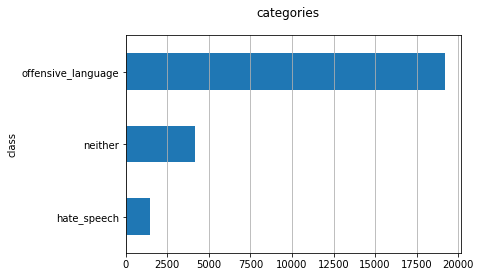

In [2]:
 # load data
df = pd.read_csv('../data/t_davidson_hate_speech_and_offensive_language.csv', index_col=0)
plot_categories(df)

sentences = df['tweet']
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
y = df[['class']]
y = y.replace({'class': mapping})['class']

In [3]:
# split into train and test (the val set will be taken from `sentences_train` during training)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.1, random_state=1000)

In [4]:
# initialize sklearn preprocessing pipeline
nltk_stop_words = pd.read_csv('../data/nltk_stop_words.csv', header=None).iloc[0].tolist()
preprocess_pipeline = Pipeline(steps=[
    ('normalize', TextPreprocessor(custom_stop_words=nltk_stop_words + ['rt', 'amp', 'ai', 'nt', 'na'])),
    ('features', TextVectorizer(enable_plots=True)),
])

# initialize sklearn classifier pipeline
classifier_pipeline = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('classifier', LSTMClassifierModel(encode_y=True, epochs=15, batch_size=128))
])

In [5]:
print(preprocess_pipeline['normalize'].nlp.Defaults.stop_words)

{'though', 'after', 'everything', 'hereupon', 'used', 'besides', 'nothing', 'amount', 'so', 'whatever', 'thereupon', 'both', 'him', 'wherein', 'go', 're', 'cannot', 'often', 'third', 'most', 'ca', 'first', 'herself', 'such', '‘re', 'that', 'am', 'few', 'next', 'together', 'anything', 'beyond', 'ours', "'s", 'since', 'which', 'even', 'no', 'than', 'nine', 'front', 'becomes', '‘m', 'were', 'move', 'keep', 'theirs', 'can', 'using', 'beside', 'under', 'off', 'his', 'thereby', 'hundred', 'well', 'they', '‘d', 'itself', 'none', 'you', 'hence', 'its', 'many', 'seemed', 'fifty', 'else', 'former', 'ourselves', 'several', 'at', 'their', 'behind', 'may', 'side', 'been', 'all', 'otherwise', 'before', 'have', 'would', 'put', 'anywhere', 'seeming', 'whole', 'up', 'already', 'against', 'being', 'elsewhere', '’re', 'of', 'per', 'whence', "'ve", 'about', 'her', 'nobody', 'whose', 'once', 'get', 'done', 'nowhere', 'indeed', 'an', 'three', 'sixty', 'had', 'as', 'in', 'thereafter', '’m', 'mine', 'with', '

../src/text_vectorizer.py:140: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


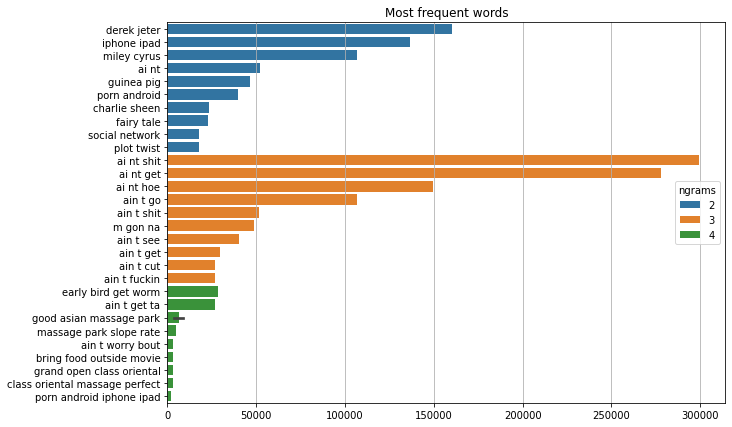

--- tokenization ---
15702 words
--- padding to sequence ---
22304 sequences of length 15


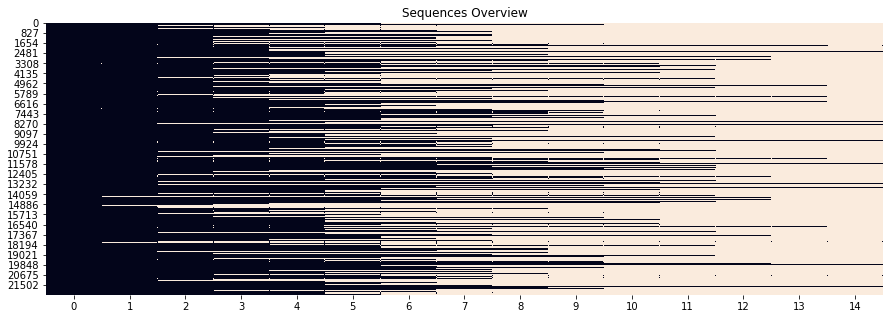

vocabulary mapped to 15703 vectors of size 300
{0: 'hate_speech', 1: 'neither', 2: 'offensive_language'}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      4710900     input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 15, 300)      0           embedding[0][0]                  
                                                                 embedding[0][0]                  
________________________________________________________________________________________

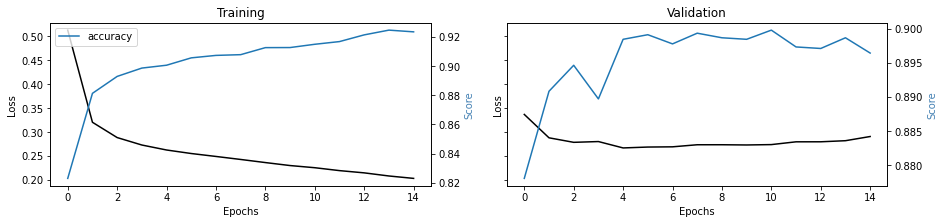

In [6]:
# train model
classifier_pipeline.fit(sentences_train, y_train)
plt.show()

In [7]:
# plot word clouds
nlp = classifier_pipeline['preprocessing']['features'].nlp
plot_w2v(lst_words=['trash'], nlp=nlp, plot_type="3d", top=20, annotate=True, figsize=(20, 5))

In [8]:
plot_w2v(lst_words=None, nlp=nlp.wv, plot_type="2d", annotate=False, figsize=(20, 5))

../src/text_vectorizer.py:140: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


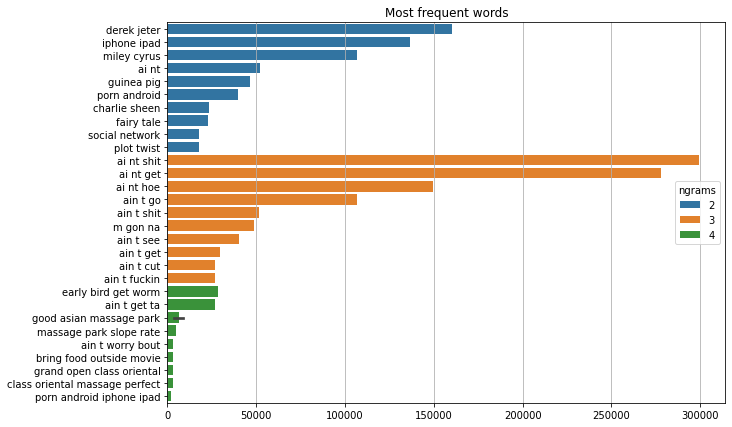

--- tokenization ---
15702 words
--- padding to sequence ---
2479 sequences of length 15


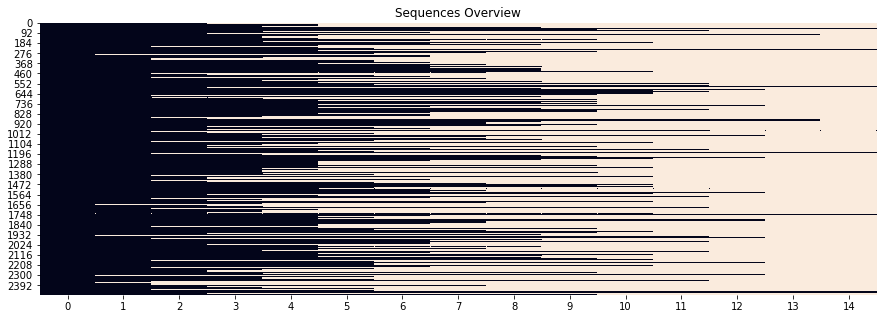

vocabulary mapped to 15703 vectors of size 300


In [9]:
# preprocess test vector
X_test, _ = preprocess_pipeline.fit_transform(sentences_test)

In [10]:
# run inference
predicted_prob, predicted = classifier_pipeline['classifier'].predict(X_test)

Accuracy: 0.9
Auc: 0.94
Detail:
                    precision    recall  f1-score   support

       hate_speech       0.47      0.38      0.42       131
           neither       0.82      0.89      0.85       438
offensive_language       0.94      0.94      0.94      1910

          accuracy                           0.90      2479
         macro avg       0.75      0.74      0.74      2479
      weighted avg       0.90      0.90      0.90      2479



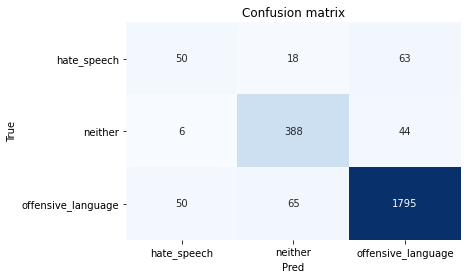

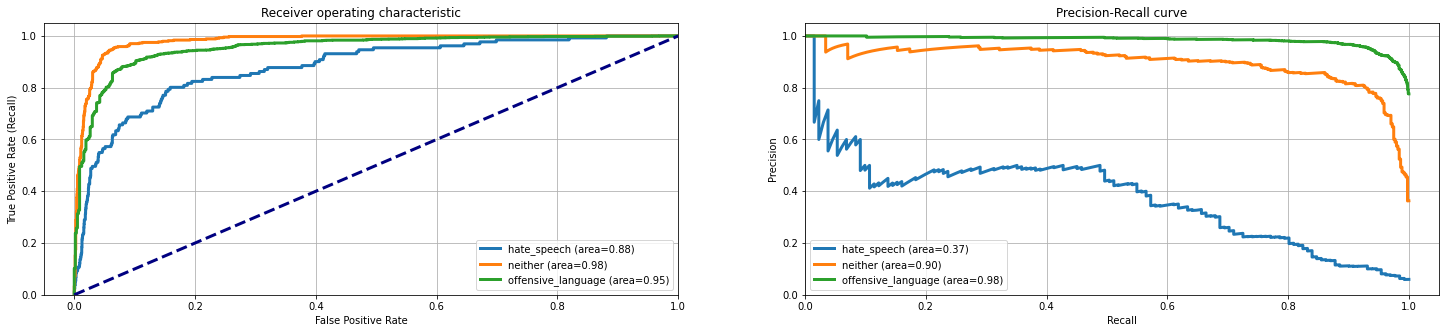

In [11]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(25, 5))

RT @ddebrinar: Smh, what a hoe. You just couldn't wait. @NayaRivera
True: offensive_language --> Pred: offensive_language | Prob: 0.99


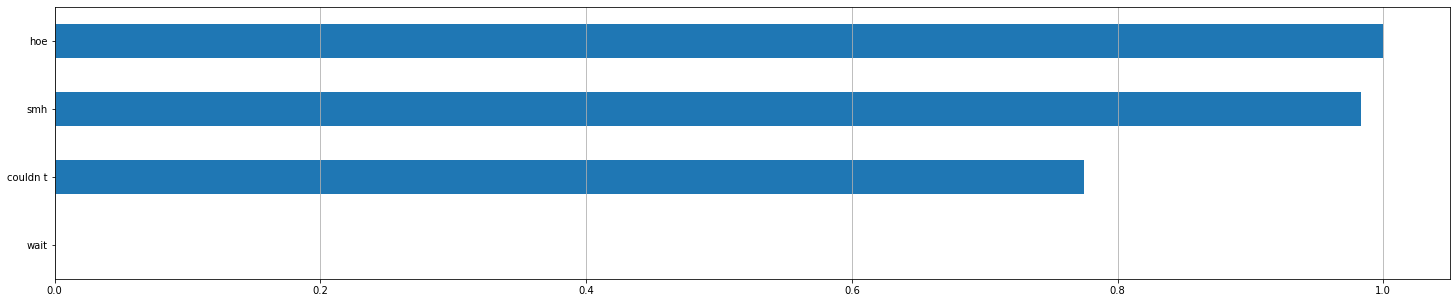

In [13]:
i = np.random.randint(0, len(sentences_test))
print(sentences_test.iloc[i])
cleaned_text = preprocess_pipeline['normalize'].transform(sentences_test.iloc[[i]]).iloc[0]
observation_dict = {
    'text': cleaned_text,
    'label': y_test.iloc[i],
    'predicted': predicted[i],
    'prediction_prob': predicted_prob[i]
}

nlp_dict = {
    'bigrams_detector': preprocess_pipeline['features'].ngrams_detector_list[0],
    'trigrams_detector': preprocess_pipeline['features'].ngrams_detector_list[1],
    'tokenizer': preprocess_pipeline['features'].fitted_tokenizer,
    'model': classifier_pipeline['classifier'].model
}

html_text = explain_observation(observation_dict, nlp_dict, top=10)

In [14]:
# export model and auxiliary info
export_all(classifier_pipeline['classifier'], preprocess_pipeline['features'], folder_out_path='/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v2')

/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v2 already contains a file named "hate_classifier.h5"!
/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v2 already contains a file named "y_labels.pickle"!
/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v2 already contains a file named "tokenizer.pickle"!
/home/cluster1/Documents/hate_speech_classifier/saved_model/hate_classifier_v2 already contains a file named "ngrams_detectors.pickle"!
